# **Deep Learning Project: Street View Housing Number Digit Recognition**


--------------
## **Context**
--------------

One of the most interesting tasks in deep learning is to recognize objects in natural scenes. The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications.

The SVHN dataset contains over 600,000 labeled digits cropped from street-level photos. It is one of the most popular image recognition datasets. It has been used in neural networks created by Google to improve the map quality by automatically transcribing the address numbers from a patch of pixels. The transcribed number with a known street address helps pinpoint the location of the building it represents.

----------------
## **Objective**
----------------

Our objective is to predict the number depicted inside the image by using Artificial or Fully Connected Feed Forward Neural Networks and Convolutional Neural Networks. We will go through various models of each and finally select the one that is giving us the best performance.

-------------
## **Dataset**
-------------
Here, we will use a subset of the original data to save some computation time. The dataset is provided as a .h5 file. The basic preprocessing steps have been applied on the dataset.

## **Mount the drive**

Let us start by mounting the Google drive. You can run the below cell to mount the Google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile

# For Data Visualization
import cv2
import seaborn as sns

# For Model Building
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model # Sequential API for sequential model
from tensorflow.keras.layers import Dense, Dropout, Flatten # Importing different layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU, Activation
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical # To perform one-hot encoding
from tensorflow.keras.optimizers import RMSprop, Adam, SGD # Optimizers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  # Regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import losses, optimizers
from tensorflow.keras.preprocessing.image import load_img
from google.colab.patches import cv2_imshow

In [ ]:
# To interact with h5 files
#!pip install h5py #to read h5

In [ ]:
import h5py

**Let us check the version of tensorflow.**

In [ ]:
print(tf.__version__)


2.15.0


## **Load the dataset**

- Let us now load the dataset that is available as a .h5 file.
- Split the data into the train and the test dataset.

In [ ]:
def load_dataset ():
  # Path to h5 file
  path = '/content/drive/MyDrive/MIT/7_elective_project/SVHN_single_grey1.h5'

  # Open the .h5 file
  h5_file = h5py.File(path, 'r')

  # List all groups
  print("DB loaded: %s" % h5_file.keys())

  X_train = h5_file['X_train'][:]
  X_val = h5_file['X_val'][:]
  X_test = h5_file['X_test'][:]
  y_train = h5_file['y_train'][:]
  y_val = h5_file['y_val'][:]
  y_test = h5_file['y_test'][:]

  # Close the file
  h5_file.close()

  return X_train,X_val,X_test,y_train,y_val,y_test

In [ ]:
X_train,X_val,X_test,y_train,y_val,y_test = load_dataset()

DB loaded: <KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>


Check the number of images in the training and the testing dataset.

In [ ]:
def print_dataset_info():
  datasets = [X_test, X_train, X_val, y_test, y_train, y_val]
  dataset_names = ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']
  for ds, name in zip(datasets, dataset_names):
      print(f"Dataset: {name}, Shape: {ds.shape}")

In [ ]:
print_dataset_info()

Dataset: X_test, Shape: (18000, 32, 32)
Dataset: X_train, Shape: (42000, 32, 32)
Dataset: X_val, Shape: (60000, 32, 32)
Dataset: y_test, Shape: (18000,)
Dataset: y_train, Shape: (42000,)
Dataset: y_val, Shape: (60000,)


Dataset consists of images of size 32*32 and labels:

* test - 18K images and labels
* train - 42K images and labels
* val - 60K images and labels

## **Visualizing images**

- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.

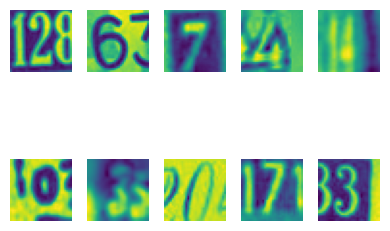

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(4, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.axis('off')

plt.tight_layout()  # Adjusts subplots to avoid overlapping
plt.show()

In [ ]:
for i in range(10):
  print(y_train[i])

2
6
7
4
4
0
3
0
7
3


In [ ]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
# Save categories for model classification report
categories = np.unique(y_train)

## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [ ]:
print(f"first image shape: {X_train[0].shape}\n\nfirst image array:\n\n{X_train[0]}")

first image shape: (32, 32)

first image array:

[[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


In [ ]:
X_train[0]

array([[ 33.0704,  30.2601,  26.852 , ...,  71.4471,  58.2204,  42.9939],
       [ 25.2283,  25.5533,  29.9765, ..., 113.0209, 103.3639,  84.2949],
       [ 26.2775,  22.6137,  40.4763, ..., 113.3028, 121.775 , 115.4228],
       ...,
       [ 28.5502,  36.212 ,  45.0801, ...,  24.1359,  25.0927,  26.0603],
       [ 38.4352,  26.4733,  23.2717, ...,  28.1094,  29.4683,  30.0661],
       [ 50.2984,  26.0773,  24.0389, ...,  49.6682,  50.853 ,  53.0377]],
      dtype=float32)

### **Normalize the train and the test data**

In [ ]:
# Normalizing the image data

X_train = X_train/255.0
X_test = X_test/255.0
X_val = X_val/255.0

In [ ]:
#sanity check
X_train[0]

array([[0.12968785, 0.11866706, 0.10530196, ..., 0.2801847 , 0.2283153 ,
        0.16860352],
       [0.09893451, 0.10020902, 0.1175549 , ..., 0.4432192 , 0.40534863,
        0.33056822],
       [0.10304902, 0.08868118, 0.15873058, ..., 0.44432473, 0.47754902,
        0.45263842],
       ...,
       [0.11196157, 0.14200786, 0.17678471, ..., 0.09465059, 0.09840274,
        0.10219726],
       [0.15072627, 0.10381687, 0.09126157, ..., 0.11023294, 0.11556196,
        0.11790627],
       [0.19724864, 0.10226392, 0.0942702 , ..., 0.19477727, 0.19942354,
        0.20799099]], dtype=float32)

Print the shapes of Training and Test data

In [ ]:
X_train.shape, X_test.shape, X_val.shape

((42000, 32, 32), (18000, 32, 32), (60000, 32, 32))

### **Flatten data**

Traditional ANN models expect 1-dimensional input. In our case 32*32 input shape = (1024)

In [ ]:
# Flatten the images

#X_train.shape[0] - specifies the number of rows 24k images, we want to keep that
# -1 - the number of columns is calculated based on the remaning dimantions 32*32 = 1024
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

In [ ]:
X_train_flat.shape, X_test_flat.shape, X_val_flat.shape

((42000, 1024), (18000, 1024), (60000, 1024))

### **One-hot encode output**

In [ ]:
#encoding
y_train_encoded = to_categorical(y_train, 10)
y_test_encoded = to_categorical(y_test, 10)
y_validation_encoded = to_categorical(y_val, 10)

In [ ]:
#sanity check for encoding
print(f"Hot encoding for: {y_train[0]}, is: {y_train_encoded[0]}")

Hot encoding for: 2, is: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


**Observation:**


Following data preparations were made to work with neural network:
* The data has been flattened form 32,32 into 32*32 = 1024 shape
* The data was normalized - can be beneficial for faster algorithm conversion
* The labels were encoded

## **Model Building**

Now that we have done the data preprocessing, let's build an ANN model.

### Fix the seed for random number generators

In [ ]:
def clear_backend_and_gen_random_seed():
  #clear the previous model's history from the Keras backend
  backend.clear_session()
  # Fixing the seed for random number generators so that we can ensure we receive the same output everytime
  np.random.seed(42)
  import random
  random.seed(42)
  tf.random.set_seed(42)

In [ ]:
clear_backend_and_gen_random_seed()

### **Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **64 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **32 nodes and the relu activation**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_1 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train an ANN model as per the above mentioned architecture.**

In [ ]:
# Intializing a sequential model
nn_model_1 = Sequential()

# First hidden layer with 64 nodes and the relu activation and the input shape = (1024, )
nn_model_1.add(Dense(64, input_shape = (1024,), activation = 'relu'))

# Second hidden layer with 32 nodes and the relu activation
nn_model_1.add(Dense(32, activation = 'relu'))

# Output layer with activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10
nn_model_1.add(Dense(10, activation = 'softmax'))


In [ ]:
#default learning rate for the Adam optimizer in TensorFlow and Keras is 0.001

nn_model_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])

In [ ]:
# Generating the summary of the model
nn_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65600     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 68010 (265.66 KB)
Trainable params: 68010 (265.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


we could also add an early stopping but here there is no such requironment

In [ ]:
# Fitting the model with 20 epochs and validation_split as 0.2

# Callback to save the best model
mc = ModelCheckpoint('nn_model_1.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

nn_model_1_history=nn_model_1.fit(X_train_flat,
          y_train_encoded,
          epochs = 20,
          batch_size= 128,
          validation_split = 0.2,
          verbose = 1,
          callbacks = [mc])

Epoch 1/20
257/263 [============================>.] - ETA: 0s - loss: 2.2947 - accuracy: 0.1228
Epoch 1: val_accuracy improved from -inf to 0.17440, saving model to nn_model_1.h5
263/263 [==============================] - 4s 6ms/step - loss: 2.2934 - accuracy: 0.1233 - val_loss: 2.2324 - val_accuracy: 0.1744
Epoch 2/20
 49/263 [====>.........................] - ETA: 0s - loss: 2.2108 - accuracy: 0.1865

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


261/263 [============================>.] - ETA: 0s - loss: 2.0782 - accuracy: 0.2503
Epoch 2: val_accuracy improved from 0.17440 to 0.30893, saving model to nn_model_1.h5
263/263 [==============================] - 1s 4ms/step - loss: 2.0774 - accuracy: 0.2509 - val_loss: 1.9318 - val_accuracy: 0.3089
Epoch 3/20
247/263 [===========================>..] - ETA: 0s - loss: 1.8744 - accuracy: 0.3382
Epoch 3: val_accuracy improved from 0.30893 to 0.38690, saving model to nn_model_1.h5
263/263 [==============================] - 1s 4ms/step - loss: 1.8679 - accuracy: 0.3405 - val_loss: 1.7779 - val_accuracy: 0.3869
Epoch 4/20
260/263 [============================>.] - ETA: 0s - loss: 1.6586 - accuracy: 0.4388
Epoch 4: val_accuracy improved from 0.38690 to 0.49071, saving model to nn_model_1.h5
263/263 [==============================] - 1s 4ms/step - loss: 1.6573 - accuracy: 0.4391 - val_loss: 1.5288 - val_accuracy: 0.4907
Epoch 5/20
248/263 [===========================>..] - ETA: 0s - loss: 1.

### **Plot the Training and Validation Accuracies and write down your Observations.**

In [ ]:
# Plotting the training and validation accuracies for each epoch

def plot_model_accuracies(model_history):
  plt.plot(model_history.history['accuracy'])
  plt.plot(model_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

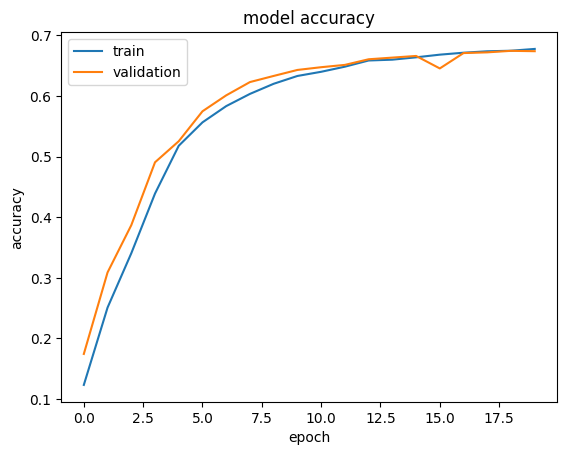

In [ ]:
plot_model_accuracies(nn_model_1_history)

### **Checking Test Accuracy**

In [ ]:
nn_model_1.evaluate(X_test_flat, (y_test_encoded))

563/563 [==============================] - 2s 4ms/step - loss: 1.0434 - accuracy: 0.6781


[1.0433531999588013, 0.6780555844306946]

**Observations:**
* The first model has 68010 trainable parameters.
* Loss ~1.04 and accurancy ~0.67.
* The train and test accuracies are constantly improving.
* Looks like the model is fitting the data well (not overfitting).
* After ~10 epochs the accuracy improvement rate is less significant, and curves are flattening out.

Let's build one more model with higher complexity and see if we can improve the performance of the model.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

### **Second Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **256 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **128 nodes and the relu activation**
 - Add the **Dropout layer with the rate equal to 0.2**
 - Third hidden layer with **64 nodes and the relu activation**
 - Fourth hidden layer with **64 nodes and the relu activation**
 - Fifth hidden layer with **32 nodes and the relu activation**
 - Add the **BatchNormalization layer**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 -Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.0005), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_2 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

In [ ]:
clear_backend_and_gen_random_seed()

In [ ]:
# Intializing a sequential model
nn_model_2 = Sequential()

# First hidden layer with 256 nodes and the relu activation and the input shape = (1024, )
nn_model_2.add(Dense(256, input_shape = (1024,), activation = 'relu'))

# Second hidden layer with 128 nodes and the relu activation
nn_model_2.add(Dense(128, activation = 'relu'))

# Dropout layer with the rate equal to 0.2 switch off 20% neurons to reduce overfitting
nn_model_2.add(Dropout(0.2))

# Third hidden layer with 64 nodes and the relu activation
nn_model_2.add(Dense(64, activation = 'relu'))

# Fourth hidden layer with 64 nodes and the relu activation
nn_model_2.add(Dense(64, activation = 'relu'))

# Fifth hidden layer with 32 nodes and the relu activation
nn_model_2.add(Dense(32, activation = 'relu'))

# BatchNormalization layer, it might be helpful to remove the problem of vanishing and exploding gradients
nn_model_2.add(BatchNormalization())

# Output layer with activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10
nn_model_2.add(Dense(10, activation = 'softmax'))

In [ ]:
# Using Adam Optimizer
optimizer = Adam(learning_rate = 0.0005)

In [ ]:
nn_model_2.compile(optimizer = optimizer, loss = 'categorical_crossentropy',  metrics = ['accuracy'])

In [ ]:
# Generating the summary of the model
nn_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization (Batch  (None, 32)                1

### **Build and train the new ANN model as per the above mentioned architecture**

In [ ]:
# Fitting the model with 30 epochs and validation_split as 0.2

# Early stopping if model validation loss doesn't improve for the next 5 epochs
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

# Callback to save the best model
mc = ModelCheckpoint('nn_model_2.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

nn_model_2_history=nn_model_2.fit(X_train_flat,
          y_train_encoded,
          epochs = 30,
          batch_size= 128,
          validation_split = 0.2,
          verbose = 1,
          callbacks = [mc,es])

Epoch 1/30
261/263 [============================>.] - ETA: 0s - loss: 2.3301 - accuracy: 0.1008
Epoch 1: val_accuracy improved from -inf to 0.09667, saving model to nn_model_2.h5
263/263 [==============================] - 10s 15ms/step - loss: 2.3300 - accuracy: 0.1007 - val_loss: 2.3138 - val_accuracy: 0.0967
Epoch 2/30
 11/263 [>.............................] - ETA: 2s - loss: 2.3086 - accuracy: 0.0973

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


262/263 [============================>.] - ETA: 0s - loss: 2.3042 - accuracy: 0.1028
Epoch 2: val_accuracy improved from 0.09667 to 0.11000, saving model to nn_model_2.h5
263/263 [==============================] - 4s 14ms/step - loss: 2.3042 - accuracy: 0.1028 - val_loss: 2.3015 - val_accuracy: 0.1100
Epoch 3/30
263/263 [==============================] - ETA: 0s - loss: 2.1699 - accuracy: 0.1746
Epoch 3: val_accuracy improved from 0.11000 to 0.27690, saving model to nn_model_2.h5
263/263 [==============================] - 5s 19ms/step - loss: 2.1699 - accuracy: 0.1746 - val_loss: 2.0564 - val_accuracy: 0.2769
Epoch 4/30
262/263 [============================>.] - ETA: 0s - loss: 1.6408 - accuracy: 0.4236
Epoch 4: val_accuracy improved from 0.27690 to 0.52726, saving model to nn_model_2.h5
263/263 [==============================] - 4s 14ms/step - loss: 1.6402 - accuracy: 0.4238 - val_loss: 1.4454 - val_accuracy: 0.5273
Epoch 5/30
260/263 [============================>.] - ETA: 0s - loss:

### **Plot the Training and Validation Accuracies and write down your Observations.**

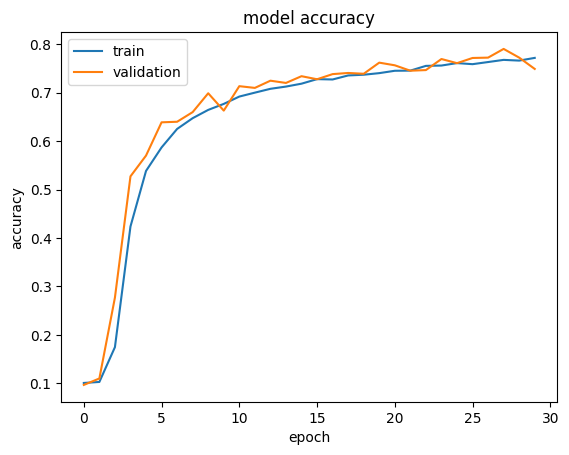

In [ ]:
# Plotting the training and validation accuracies for each epoch
plot_model_accuracies(nn_model_2_history)

### **Checking Test Accuracy**

In [ ]:
nn_model_2.evaluate(X_test_flat, (y_test_encoded))

563/563 [==============================] - 2s 4ms/step - loss: 0.8357 - accuracy: 0.7447


[0.835655152797699, 0.7447222471237183]

**Observations:**
* ANN model 2 has more trainable parameters - 310186 as opposed to 68010 for ANN model 1.
* The ANN model 2 is outperforming the ANN model 1 after ~6 epochs.
* The loss for ANN model 2 is smaller ~0.8 as opposed to ~1.04 for ANN model 1 and the accuracy is higher ~0.75 compared to ~0.67 for ANN model 1.
* After ~12 epochs the curves are flattening out, with no significant improvement.
* Early stopping was no triggered.
* After ~7 epochs the validation accuracy started fluctuating, as the train accuracy continued to improve.

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = nn_model_2.predict(X_test_flat)
pred = np.argmax(pred, axis = 1)
y_true = np.argmax(y_test_encoded, axis = 1)


563/563 [==============================] - 2s 3ms/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

We already have categories stored earlier, we can now use it for our report

In [ ]:
# Convert list of categories/labels to list of strings
categories = [str(x) for x in categories.tolist()]

In [ ]:
categories

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

### **Print the classification report and the confusion matrix for the test predictions. Write your observations on the final results.**

In [ ]:
# Printing the classification report
print(classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.86      0.70      0.77      1814
           1       0.59      0.89      0.71      1828
           2       0.76      0.77      0.76      1803
           3       0.78      0.67      0.72      1719
           4       0.73      0.85      0.79      1812
           5       0.82      0.67      0.73      1768
           6       0.76      0.72      0.74      1832
           7       0.75      0.82      0.78      1808
           8       0.71      0.71      0.71      1812
           9       0.83      0.65      0.73      1804

    accuracy                           0.74     18000
   macro avg       0.76      0.74      0.74     18000
weighted avg       0.76      0.74      0.74     18000



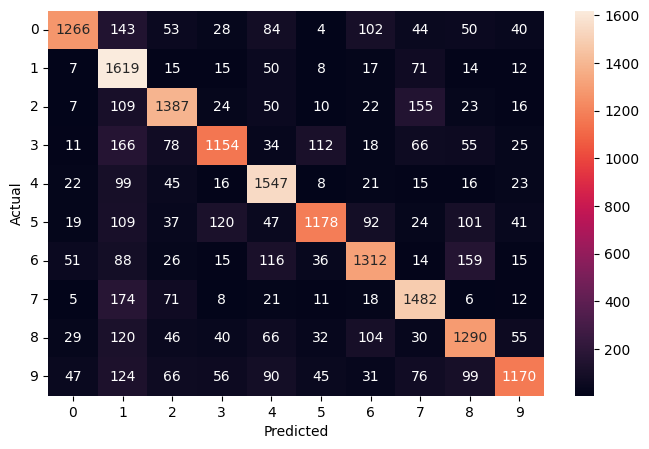

In [ ]:
# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = categories, yticklabels=categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.yticks(rotation=0)
plt.show()

**Final Observations:**
* ANN Model 2 prediction F1 score accuracy is ~74%
* There are many misclassifications, especially for classes: "0","3","5","9".
* Example: 7 was misclassified as 1 for 174 times in this dataset. The least misclassified classes are "1" and "4".

## **Using Convolutional Neural Networks**

### **Load the dataset again and split the data into the train and the test dataset.**

In [ ]:
X_train,X_val,X_test,y_train,y_val,y_test = load_dataset()

DB loaded: <KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>


Check the number of images in the training and the testing dataset.

In [ ]:
X_train.shape, X_val.shape, X_test.shape

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((42000,), (60000,), (18000,))

**Observation:**
* There are 42K images in the training dataset 60K in validation and 18K in test.
* Each image is of size 32*32.
* There are a corresponding number of labels 42K, 60K, 18K.

## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Reshape the train and the test dataset because we always have to give a 4D array as input to CNNs.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [ ]:
#Printing shape and the array of pixels for the first image
print(f"Shape of an image: {X_train[0].shape},\n\n Array of pixels: \n{X_train[0]}")

Shape of an image: (32, 32),

 Array of pixels: 
[[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


Reshape the dataset to be able to pass them to CNNs. Remember that we always have to give a 4D array as input to CNNs

In [ ]:
# Reshape for color image
X_train_4D = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test_4D = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val_4D = X_val.reshape(X_val.shape[0], 32, 32, 1)

Normalize inputs from 0-255 to 0-1

In [ ]:
X_train_4D = X_train_4D/255
X_test_4D = X_test_4D/255
X_val_4D = X_val_4D/255

Print New shape of Training and Test

In [ ]:
X_train_4D.shape, X_test_4D.shape, X_val_4D.shape

((42000, 32, 32, 1), (18000, 32, 32, 1), (60000, 32, 32, 1))

In [ ]:
y_train.shape, y_test.shape, y_val.shape

((42000,), (18000,), (60000,))

### **One-hot encode the labels in the target variable y_train and y_test.**

In [ ]:
#encoding
y_train_encoded = to_categorical(y_train, 10)
y_test_encoded = to_categorical(y_test, 10)
y_validation_encoded = to_categorical(y_val, 10)

In [ ]:
#sanity check for encoding
print(f"Hot encoding for: {y_train[0]}, is: {y_train_encoded[0]}")

Hot encoding for: 2, is: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


**Observation:**
* The data is now in the format of 4D so we can pass it into CNN:
  * Number of images, width, height, RGB
* The labels have been encoded
* Train has 42K images, Test 18K, and Validation 60K images with a matching number of labels

## **Model Building**

Now that we have done data preprocessing, let's build a CNN model.
Fix the seed for random number generators

In [ ]:
clear_backend_and_gen_random_seed()

### **Model Architecture**
- **Write a function** that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Another **LeakyRelu** with the **slope equal to 0.1**
 - A **max-pooling layer** with a **pool size of 2x2**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_1 and store the output in a new variable.
- Print the summary of the model.
- Fit the model on the training data with a **validation split of 0.2, batch size = 32, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

In [ ]:
# Intializing a sequential model
cnn_model_1 = Sequential()

# First Convolutional layer with 16 filters and the kernel size of 3x3. 'same' padding and input shape = (32, 32, 1)
cnn_model_1.add(Conv2D(16, (3, 3), padding = "same", input_shape = (32, 32, 1)))

# Adding LeakyRelu activation function with a negative slope of 0.1
cnn_model_1.add(LeakyReLU(0.1))

# Second Convolutional layer with 32 filters and the kernel size of 3x3 with 'same' padding
cnn_model_1.add(Conv2D(32, (3, 3), padding = "same"))

# Adding LeakyRelu activation function with a negative slope of 0.1
cnn_model_1.add(LeakyReLU(0.1))

# A max-pooling layer with a pool size of 2x2
cnn_model_1.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the output from the previous layer
cnn_model_1.add(Flatten())

# Dense layer with 32 nodes
cnn_model_1.add(Dense(32))

# Adding LeakyRelu activation function with a negative slope of 0.1
cnn_model_1.add(LeakyReLU(0.1))

# Adding the final output layer with nodes equal to the number of classes
cnn_model_1.add(Dense(10, activation = 'softmax'))

In [ ]:
# Compiling the model with the loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001),
# and metric equal to 'accuracy'.

optimizer = Adam(learning_rate = 0.001)
cnn_model_1.compile(optimizer = optimizer, loss = 'categorical_crossentropy',  metrics = ['accuracy'])

In [ ]:
# Generating the summary of the model
cnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                        

### **Build and train a CNN model as per the above mentioned architecture.**

In [ ]:
# Callback to save the best model
mc = ModelCheckpoint('cnn_model_1.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

# Fitting the model on the training data with a validation split of 0.2, batch size = 32, verbose = 1, and epochs = 20
cnn_model_1_hystory = cnn_model_1.fit(X_train_4D,
                                      y_train_encoded,
                                      validation_split = 0.2,
                                      epochs = 20,
                                      batch_size = 32,
                                      verbose = 1,
                                      callbacks = [mc])

Epoch 1/20
1050/1050 [==============================] - ETA: 0s - loss: 1.1274 - accuracy: 0.6303
Epoch 1: val_accuracy improved from -inf to 0.80869, saving model to cnn_model_1.h5
1050/1050 [==============================] - 83s 76ms/step - loss: 1.1274 - accuracy: 0.6303 - val_loss: 0.6497 - val_accuracy: 0.8087
Epoch 2/20
1050/1050 [==============================] - ETA: 0s - loss: 0.5352 - accuracy: 0.8475
Epoch 2: val_accuracy improved from 0.80869 to 0.84476, saving model to cnn_model_1.h5
1050/1050 [==============================] - 77s 73ms/step - loss: 0.5352 - accuracy: 0.8475 - val_loss: 0.5254 - val_accuracy: 0.8448
Epoch 3/20
1050/1050 [==============================] - ETA: 0s - loss: 0.4416 - accuracy: 0.8700
Epoch 3: val_accuracy improved from 0.84476 to 0.85321, saving model to cnn_model_1.h5
1050/1050 [==============================] - 77s 74ms/step - loss: 0.4416 - accuracy: 0.8700 - val_loss: 0.5049 - val_accuracy: 0.8532
Epoch 4/20
1050/1050 [=====================

### **Plot the Training and Validation Accuracies and Write your observations.**

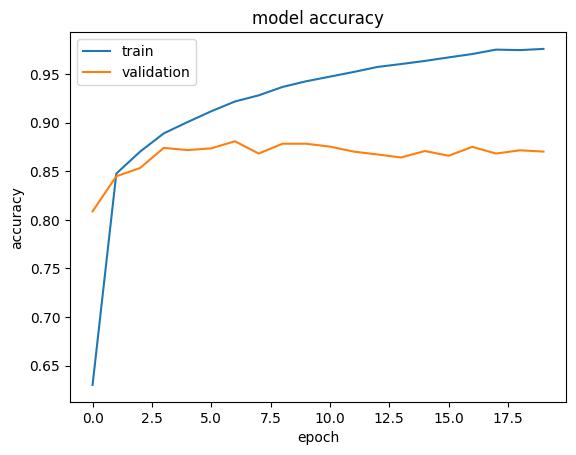

In [ ]:
# Plotting the training and validation accuracies for each epoch
plot_model_accuracies(cnn_model_1_hystory)

**Observations:**
* The CNN model 1 has 267306 trainable parameters.
* The CNN model 1 seems to overfit, while the accuracy on training data improves, the accurancy on the validation data starts fluctuating after first epoch.
* Relatively big delta between traning and validation data accurancy.

Let's build another model and see if we can get a better model with generalized performance.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [ ]:
clear_backend_and_gen_random_seed()

### **Second Model Architecture**

- Write a function that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add **LeakyRelu** with the **slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - Third Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Fourth Convolutional layer **64 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **dropout layer with the rate equal to 0.5**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_2 and store the model in a new variable.
- Print the summary of the model.
- Fit the model on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the second CNN model as per the above mentioned architecture.**

In [ ]:
cnn_model_2 = Sequential()

# First Convolutional layer with 16 filters and the kernel size of 3x3. 'same' padding and input shape = (32, 32, 1)
cnn_model_2.add(Conv2D(16, (3, 3), padding = "same", input_shape = (32, 32, 1)))

# Adding LeakyRelu with the slope equal to 0.1
cnn_model_2.add(LeakyReLU(0.1))

# Second Convolutional layer with 32 filters and the kernel size of 3x3 with 'same' padding
cnn_model_2.add(Conv2D(32, (3, 3),  padding = "same"))

# Adding LeakyRelu with the slope equal to 0.1
cnn_model_2.add(LeakyReLU(0.1))

# Adding a max-pooling layer with a pool size of 2x2
cnn_model_2.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a BatchNormalization layer
cnn_model_2.add(BatchNormalization())

# Third Convolutional layer with 32 filters and the kernel size of 3x3 with 'same' padding
cnn_model_2.add(Conv2D(32, (3, 3),  padding = "same"))

# Adding a LeakyRelu layer with the slope equal to 0.1
cnn_model_2.add(LeakyReLU(0.1))

# Fourth Convolutional layer 64 filters and the kernel size of 3x3 with 'same' padding
cnn_model_2.add(Conv2D(64, (3, 3),  padding = "same"))

# Adding a LeakyRelu layer with the slope equal to 0.1
cnn_model_2.add(LeakyReLU(0.1))

# Adding a max-pooling layer with a pool size of 2x2
cnn_model_2.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a BatchNormalization layer
cnn_model_2.add(BatchNormalization())

# Adding Flutten layer
cnn_model_2.add(Flatten())

# Dense layer with 32 nodes
cnn_model_2.add(Dense(32))

# Adding LeakyRelu activation function with a negative slope of 0.1
cnn_model_2.add(LeakyReLU(0.1))

# Adding a dropout layer with the rate equal to 0.5
cnn_model_2.add(Dropout(0.5))

# Adding the final output layer with nodes equal to the number of classes
cnn_model_2.add(Dense(10, activation = 'softmax'))

In [ ]:
# Compileing the model with the categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and metric equal to 'accuracy'.

optimizer = Adam(learning_rate = 0.001)
cnn_model_2.compile(optimizer = optimizer, loss = 'categorical_crossentropy',  metrics = ['accuracy'])

In [ ]:
cnn_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                          

### **Plot the Training and Validation accuracies and write your observations.**

In [ ]:
# Callback to save the best model
mc = ModelCheckpoint('cnn_model_2.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

# Fit the model on the train data with a validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30.
cnn_model_2_hystory = cnn_model_2.fit(X_train_4D,
                                      y_train_encoded,
                                      validation_split = 0.2,
                                      epochs = 30,
                                      batch_size = 128,
                                      verbose = 1,
                                      callbacks = [mc])

Epoch 1/30
263/263 [==============================] - ETA: 0s - loss: 1.3222 - accuracy: 0.5483
Epoch 1: val_accuracy improved from -inf to 0.21119, saving model to cnn_model_2.h5
263/263 [==============================] - 129s 482ms/step - loss: 1.3222 - accuracy: 0.5483 - val_loss: 2.1225 - val_accuracy: 0.2112
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


263/263 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.7950
Epoch 2: val_accuracy improved from 0.21119 to 0.82083, saving model to cnn_model_2.h5
263/263 [==============================] - 131s 497ms/step - loss: 0.6654 - accuracy: 0.7950 - val_loss: 0.6373 - val_accuracy: 0.8208
Epoch 3/30
263/263 [==============================] - ETA: 0s - loss: 0.5528 - accuracy: 0.8313
Epoch 3: val_accuracy improved from 0.82083 to 0.87369, saving model to cnn_model_2.h5
263/263 [==============================] - 130s 496ms/step - loss: 0.5528 - accuracy: 0.8313 - val_loss: 0.4480 - val_accuracy: 0.8737
Epoch 4/30
263/263 [==============================] - ETA: 0s - loss: 0.4908 - accuracy: 0.8507
Epoch 4: val_accuracy improved from 0.87369 to 0.88226, saving model to cnn_model_2.h5
263/263 [==============================] - 123s 468ms/step - loss: 0.4908 - accuracy: 0.8507 - val_loss: 0.3992 - val_accuracy: 0.8823
Epoch 5/30
263/263 [==============================] - ETA

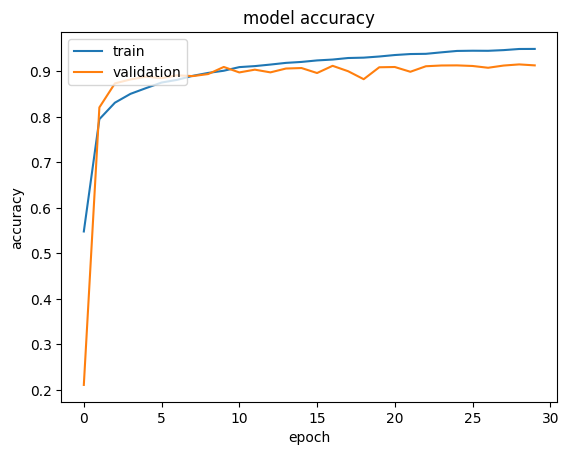

In [ ]:
# Plotting the training and validation accuracies for each epoch

plt.plot(cnn_model_2_hystory.history['accuracy'])
plt.plot(cnn_model_2_hystory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Model accuracy
cnn_model_2.evaluate(X_test_4D, (y_test_encoded))

563/563 [==============================] - 18s 31ms/step - loss: 0.4699 - accuracy: 0.9129


[0.46987923979759216, 0.9129444360733032]

**Observations:**
* CNN model 2 has 164,170 trainable parameters, compared to CNN model 1 - 267306.
* The model fits the data well since there is no big gap between training and validation accuracy.
* After 5 epochs the curves are flattening out, which means there is no significant improvement in accuracy.
* CNN model 2 loss: 0.4699 and accuracy: 0.9129 which is better compared to other ANN model 2 with loss: 0.8357 - accuracy: 0.7447.
* It's a good idea to use the early stopping callback next time since the accuracy improvement for the late cycles is insignificant, and it would save computing time.
* CNN model 2 has less trainable parameters - 164170 , compared to ANN model 2 - 310186.

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

### **Make predictions on the test data using the second model.**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = cnn_model_2.predict(X_test_4D)
pred = np.argmax(pred, axis = 1)
y_true = np.argmax(y_test_encoded, axis = 1)

563/563 [==============================] - 18s 31ms/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector, but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

We already have Categories stored earlier, no need to convert in this case.

In [ ]:
# Printing the classification report
print(classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1814
           1       0.92      0.90      0.91      1828
           2       0.93      0.93      0.93      1803
           3       0.89      0.90      0.89      1719
           4       0.93      0.92      0.92      1812
           5       0.91      0.91      0.91      1768
           6       0.89      0.90      0.90      1832
           7       0.94      0.93      0.93      1808
           8       0.92      0.88      0.90      1812
           9       0.92      0.90      0.91      1804

    accuracy                           0.91     18000
   macro avg       0.91      0.91      0.91     18000
weighted avg       0.91      0.91      0.91     18000



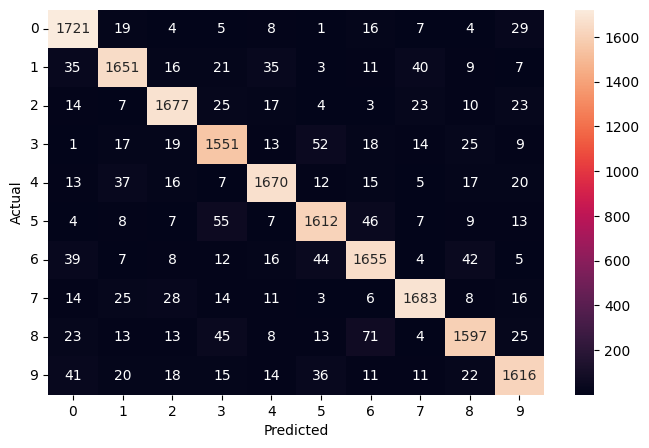

In [ ]:
# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = categories, yticklabels=categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.yticks(rotation=0)
plt.show()

### **Write your final observations on the performance of the model on the test data.**

**Observations for CNN model 2:**
* CNN Model 2 prediction F1 score accuracy is ~91%
* There are some misclassifications but not as many as for ANN models.
  * For example "7" was misclassified as "1" 25 times, as opposed to 174 times for ANN model 2

**Note:**
It would be a great idea to load the models we stored earlier to compare them (example keras load_model("cnn_model_1.h5")) but since the notebook was out of GPU and was constantly reconnected we no longer have access to these stored models. Let's collect and print the results manually.

In [ ]:
loss = [1.0434,0.8357,0.8155,0.4699]
accuracy = [0.6781,0.7447,0.8701,0.9129]
num_params = [68010,310186,267306,164170]

evaluation_results = []

for i in range(4):
  evaluation_results.append({'Loss': loss[i], 'Accuracy': accuracy[i], 'Number parameters': num_params[i]})

# Create a DataFrame for comparison
comparison_table = pd.DataFrame(evaluation_results, index=['ANN Model 1','ANN Model 2','CNN Model 1', 'CNN Model 2'])

In [ ]:
comparison_table

,Loss,Accuracy,Number parameters
ANN Model 1,1.0434,0.6781,68010
ANN Model 2,0.8357,0.7447,310186
CNN Model 1,0.8155,0.8701,267306
CNN Model 2,0.4699,0.9129,164170


**Final Observations:**
* ANN model 2 outperformed ANN model 1.
* CNN model 2 outperformed ANN model 2.
* CNN model 1 was overfitting.
* CNN model 2 fits the data well.
* The validation set hasn't been used, for all the model's requirements, there was already a predefined requirement on validation split %.

Among all the models CNN model 2 gave the best results, however, it took longer to train it, we can add an early stopping next time.

**Recommendations & Next steps**:
* CNN model 2 is the best model among all the suggested, not only it gave the best results, but also the number of parameters was less than in ANN model 2.
* Try to tune the CNN model 2 for better performance.
* Make use of the Validation set to improve model performance.
* The training dataset can be increased by distorting the images (augmentation etc..) training the model on it can also improve the model performance.